## IKEA business case 

### The case
As a Data Analyst at IKEA you contribute to improving the everyday life of the many people by enabling co-workers and customers to take better actions. In the following case you will be working like you are a Data Analyst in a product team, which will imply that you will have a mixed composition of technical (other Data Analysts or Scientists for instance) and non-technical members (Product Owner or UX Designer). 


### Intro
You are a Data Analyst working as part of a team that is revolutionizing the digital experience of the costumers in IKEA. Among the many task that this implies, your team has developed a new system that allow customers to buy items in a Virtual Reality tour.

After launching it, the team asks you to analyze the data to understand what kind of costumers have tested the new product and what are the main insights that can be obtained.

In this exercise the available dataset contains one day of individual product transactions in a single retail store: item ID, item categorization and sales amount. Furthermore, each transaction is labeled with a specific customer ID as well as supplementary information about that customer, for example whether that customer has children or not.

### Please respond to all the questions below

**Question 1**
<br>
Propose a segmentation analysis and explain the main insights obtained to your team.

**Question 2** 
<br>
What kind of data would you like to have to improve your analysis and back-up the insights that you mentioned?

**Question 3** 
<br>
The team wants to keep developing new features that are personalized for each of the segments that you mentioned with the goal of increasing sales. According to your analysis, what segment should they focus at first?

**Question 4**
<br>
Although the team really appreciated your feedback and insights, since there is a large stock of children items, they are asked to focus the new products on costumers that have children in order to do not waste any of those products.

For some customers, their children status (column “HaveChildren”) is unknown. This is indicated by an empty record instead of a “0” or “1”. 

After some initial data exploration, you determine that it should be possible to predict the missing values / get insights on what characteristics are associated with having kids. 

You decide to attempt to visualize for the team what fields are likely to predict the “HaveChildren” column.

Specifically, generate (and attach to your answer) visualizations, that tells a clear story about what customer characteristics are likely to predict the customers having children.

Include a short synthesis of what insights you draw from your visualizations.


## Table of Content 
<ul>
<li><a href="#Question1">Data preparation</a></li>
<li><a href="#Question2">Main insights and key findings (Question 1)</a></li>
<li><a href="#Question3">Customer segmentation summary (Question 1)</a></li>
<li><a href="#Question4">Data points which can help to improve analysis (Question 2)</a></li>
<li><a href="#Question5">Type of customer who we should proritize(Question3)</a></li>
<li><a href="#Question6">Priorizised customer suggestion (Question3)</a></li>
<li><a href="#Question7">Have Chirldren or not prediction (Question 4)</a></li>
<li><a href="#Question8">Prediction summary (Question 4)</a></li>
<ul>

<a id='Question1'></a>
### Data preparation

<a href="#Table-of-Content">Back up</a>

In [1]:
#Import the libraries I need use for this analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from time import time
from sklearn.metrics import fbeta_score, accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import visuals as vs
import warnings
from sklearn.utils import resample
warnings.filterwarnings("ignore")

In [2]:
# read the data
df = pd.read_csv('RetailCustomerSales.csv',sep=';')
df.head(10)

,CustomerID,ItemID,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,ItemCategory1,ItemCategory2,ItemCategory3,Amount
0,1000001,P00069042,F,0-17,10,A,2,0.0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0.0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0.0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0.0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0.0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0.0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1.0,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1.0,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1.0,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1.0,8,NaN,NaN,7871


#### Data size

In [3]:
print('Row and column number of data: {}'.format(df.shape))
df.shape

Row and column number of data: (537577, 12)


(537577, 12)

#### Data type and content

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CustomerID     537577 non-null  int64  
 1   ItemID         537577 non-null  object 
 2   Sex            537577 non-null  object 
 3   Age            537577 non-null  object 
 4   Profession     537577 non-null  int64  
 5   CityType       537577 non-null  object 
 6   YearsInCity    537577 non-null  object 
 7   HaveChildren   517407 non-null  float64
 8   ItemCategory1  537577 non-null  int64  
 9   ItemCategory2  370591 non-null  float64
 10  ItemCategory3  164278 non-null  float64
 11  Amount         537577 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 49.2+ MB


There are few data type are not appropriate. For example, ``CustomerID`` can be integer but we'd better change it as string since we are not going to aggregate the ID. ``Profession`` should be string. ``ItemCategory2`` and ``ItemCategory2`` better use integer instead of float. 

#### Check missing data

In [7]:
#check columns with missing data
def assess_missing_data(df):
    
    rec = []
    for column_name in df.columns:
        miss_count = df[column_name].isnull().sum(axis=0)
        miss_percent=miss_count/df.shape[0]
        rec.append([column_name,miss_count,miss_percent*100])
        df_stats = pd.DataFrame.from_records(rec, columns = ['column name', 
                                                             'missing_count','missing_percentage'])  
        df_stats = df_stats.sort_values('missing_percentage',axis=0, ascending = False )
    return df_stats

df_stats = assess_missing_data(df)

df_stats

,column name,missing_count,missing_percentage
10,ItemCategory3,373299,69.441029
9,ItemCategory2,166986,31.062713
7,HaveChildren,20170,3.752021
0,CustomerID,0,0.000000
1,ItemID,0,0.000000
2,Sex,0,0.000000
3,Age,0,0.000000
4,Profession,0,0.000000
5,CityType,0,0.000000
6,YearsInCity,0,0.000000


Text(0.5, 0, 'number of missing data')

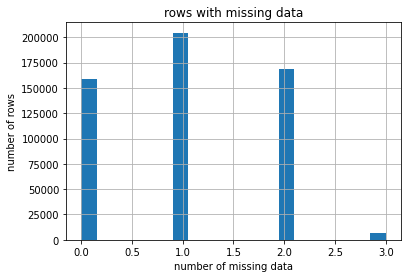

In [8]:
# Plot the missing rows
df.isnull().sum(axis=1).hist(bins = 20)
plt.title('rows with missing data')
plt.ylabel('number of rows')
plt.xlabel('number of missing data')

In [9]:
# understand why the data is missing, think what method I can use to fill the data or drop the data
df[['ItemCategory2','ItemCategory3']].head()

,ItemCategory2,ItemCategory3
0,NaN,NaN
1,6.0,14.0
2,NaN,NaN
3,14.0,NaN
4,NaN,NaN


As we can see that ``ItemCategory2`` and ``ItemCategory2`` have missing data is because there are some products do not have more than 1 categories, so we can just fill the null value with **0**

In [4]:
#Fill 'ItemCategory2'and'ItemCategory3' with 0 and change the data type
df[['ItemCategory2','ItemCategory3']] = df[['ItemCategory2','ItemCategory3']].fillna(0).astype('int64')
df[['CustomerID','Profession']] = df[['CustomerID','Profession']].astype('str')

In [11]:
#check again the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CustomerID     537577 non-null  object 
 1   ItemID         537577 non-null  object 
 2   Sex            537577 non-null  object 
 3   Age            537577 non-null  object 
 4   Profession     537577 non-null  object 
 5   CityType       537577 non-null  object 
 6   YearsInCity    537577 non-null  object 
 7   HaveChildren   517407 non-null  float64
 8   ItemCategory1  537577 non-null  int64  
 9   ItemCategory2  537577 non-null  int64  
 10  ItemCategory3  537577 non-null  int64  
 11  Amount         537577 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 49.2+ MB


#### Deal with ``categories`` data
Right now, one product can belong to 1 to 3 different categories. Each category appears in one column: ``ItemCategory1``,``ItemCategory2`` and ``ItemCategory3``. To be able to make later calculationo on these categoriees data (like count total categories per demographic characteristics or customers), we can dummy these categories into different columns.

In [5]:
# create a function to dummy all the columns related with category
def columns_to_dummies(df, prefix='Category_'):
    result = pd.DataFrame(index=df.index)
    for c in df.columns:
        dummies = pd.get_dummies(df[c])
        for c2 in dummies.columns:
            if c2 in result.columns:
                result[c2] += dummies[c2]
            else:
                result[c2] = dummies[c2]
    return result.rename(columns=lambda x: prefix + str(x))

df_to_dummy = df[['ItemCategory1', 'ItemCategory2', 'ItemCategory3']]
df_category_dummy = columns_to_dummies(df_to_dummy, 'Category_')

df = pd.concat([df, df_category_dummy], axis=1)

df = df.drop(columns=['Category_0', 'ItemCategory1', 'ItemCategory2', 'ItemCategory3'])

In [6]:
pd.set_option('display.max_columns', None)
df.head(5)

,CustomerID,ItemID,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,Amount,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,Category_11,Category_12,Category_13,Category_14,Category_15,Category_16,Category_17,Category_18
0,1000001,P00069042,F,0-17,10,A,2,0.0,8370,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000001,P00248942,F,0-17,10,A,2,0.0,15200,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1000001,P00087842,F,0-17,10,A,2,0.0,1422,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1000001,P00085442,F,0-17,10,A,2,0.0,1057,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,1000002,P00285442,M,55+,16,C,4+,0.0,7969,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


#### Create table by grouping the unique customers

As we can see from the current table, the table is break down by item ID, but we want to see a table with group by the unique customers

In [7]:
top_amount = df.groupby('CustomerID', as_index=False)['Amount'].sum()
top_units = df.groupby('CustomerID', as_index=False)['ItemID'].nunique()
categories = df.groupby('CustomerID')[['Category_' + str(i) for i in range(1,19)]].sum()

unique_customer = pd.merge(top_amount, top_units, on = 'CustomerID')
unique_customer['avg_spend'] = round((unique_customer['Amount']/unique_customer['ItemID']),2)
unique_customer =  pd.merge(unique_customer, categories, on = 'CustomerID')
unique_customer = unique_customer.rename(columns = {'ItemID': 'purchased_units'})
unique_customer.head()

,CustomerID,Amount,purchased_units,avg_spend,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,Category_11,Category_12,Category_13,Category_14,Category_15,Category_16,Category_17,Category_18
0,1000001,333481,34,9808.26,4.0,3.0,11.0,13.0,5.0,2.0,0.0,13.0,2.0,0.0,0.0,8.0,0.0,3.0,1.0,2.0,2.0,0.0
1,1000002,810353,76,10662.54,31.0,9.0,0.0,0.0,15.0,9.0,0.0,46.0,1.0,1.0,2.0,0.0,3.0,10.0,7.0,14.0,7.0,1.0
2,1000003,341635,29,11780.52,15.0,15.0,1.0,1.0,15.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0
3,1000004,205987,13,15845.15,13.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,5.0,3.0,1.0,0.0
4,1000005,821001,106,7745.29,18.0,5.0,2.0,4.0,26.0,9.0,5.0,57.0,0.0,1.0,5.0,2.0,4.0,13.0,6.0,21.0,2.0,0.0


Now we can also join the unique customer table with other demography features and make out final table to use.

In [8]:
df_clean = pd.merge(unique_customer,df[['CustomerID','Sex', 'Age', 'Profession', 'CityType','YearsInCity','HaveChildren']].drop_duplicates(), on ='CustomerID')

In [16]:
df_clean.head(5)

,CustomerID,Amount,purchased_units,avg_spend,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,Category_11,Category_12,Category_13,Category_14,Category_15,Category_16,Category_17,Category_18,Sex,Age,Profession,CityType,YearsInCity,HaveChildren
0,1000001,333481,34,9808.26,4.0,3.0,11.0,13.0,5.0,2.0,0.0,13.0,2.0,0.0,0.0,8.0,0.0,3.0,1.0,2.0,2.0,0.0,F,0-17,10,A,2,0.0
1,1000002,810353,76,10662.54,31.0,9.0,0.0,0.0,15.0,9.0,0.0,46.0,1.0,1.0,2.0,0.0,3.0,10.0,7.0,14.0,7.0,1.0,M,55+,16,C,4+,0.0
2,1000003,341635,29,11780.52,15.0,15.0,1.0,1.0,15.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0,M,26-35,15,A,3,0.0
3,1000004,205987,13,15845.15,13.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,5.0,3.0,1.0,0.0,M,46-50,7,B,2,1.0
4,1000005,821001,106,7745.29,18.0,5.0,2.0,4.0,26.0,9.0,5.0,57.0,0.0,1.0,5.0,2.0,4.0,13.0,6.0,21.0,2.0,0.0,M,26-35,20,A,1,1.0


In [17]:
# Save this data as csv to send back to IKEA
df_clean.to_csv('IKEA_business_case_clean_data.csv',index=False)

<a id='Question2'></a>
### Main insights and key findings

<a href="#Table-of-Content">Back up</a>

#### How many unique customers appears in this data?

In [18]:
print("The number of unique customer:{}".format(df['CustomerID'].nunique()))

The number of unique customer:5891


#### Customer Sex Distribution

In [14]:
# Prepare a function for ploting all the features
def plot_demography(features, color):
    ax = df_clean.groupby(features)['CustomerID'].count().sort_values().plot(x=features, y ='count', kind='barh',\
              figsize=(5,4), fontsize=12, width = 0.8, color = color, zorder=3)
    ax.set_title("Customer distribution by " + str(features), fontdict={'fontsize': 14, 'fontweight': 'medium'})
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    ax.grid(color = 'w', zorder=0)

    for spine in ax.spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_facecolor('whitesmoke')
        
    
    plt.figure()
    df_clean[features].value_counts().plot.pie(textprops={'color':"w"},pctdistance=0.7,autopct='%.2f%%', figsize=(5,5),labels=None,subplots=True)
    plt.title(str(features) +' Percentage Distribution',fontsize=14,ha='right')
    plt.legend(labels=df_clean[features].value_counts().index, loc="best",bbox_to_anchor=(1, 0.25, 0.5, 0.5))
    plt.show()
        
# Prepare a function for showing table
def show_table(features):
    return df_clean.groupby(features, as_index=False )['CustomerID'].count().sort_values('CustomerID',ascending = False)   

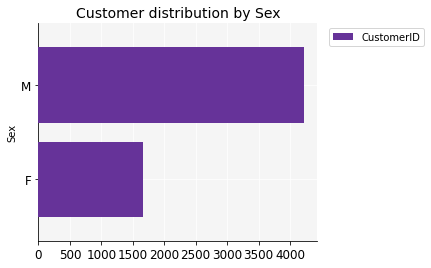

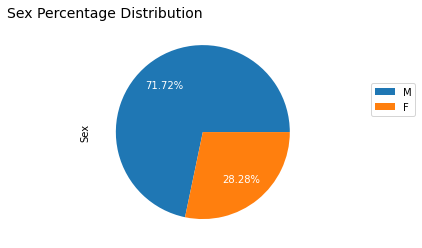

,Sex,CustomerID
1,M,4225
0,F,1666


In [15]:
plot_demography('Sex', 'rebeccapurple')
show_table('Sex')

#### Customer Age Distribution

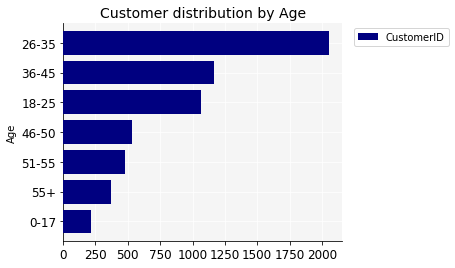

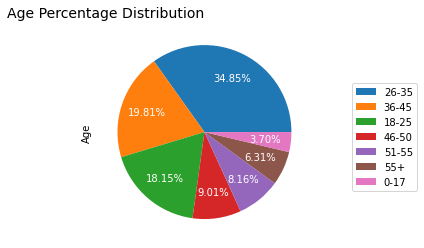

,Age,CustomerID
2,26-35,2053
3,36-45,1167
1,18-25,1069
4,46-50,531
5,51-55,481
6,55+,372
0,0-17,218


In [16]:
plot_demography('Age', 'navy')
show_table('Age')

#### Customer Profession Distribution

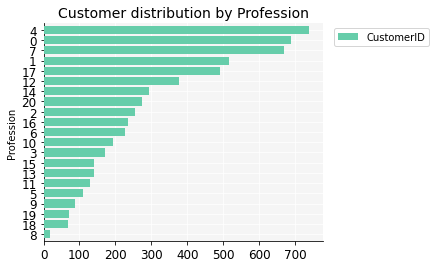

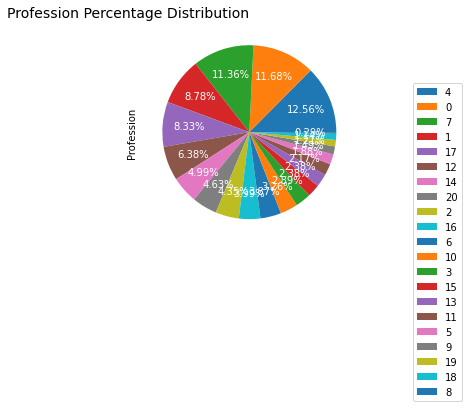

,Profession,CustomerID
15,4,740
0,0,688
18,7,669
1,1,517
9,17,491
4,12,376
6,14,294
13,20,273
12,2,256
8,16,235


In [17]:
plot_demography('Profession', 'mediumaquamarine')
show_table('Profession')

#### Customer With Children or Not

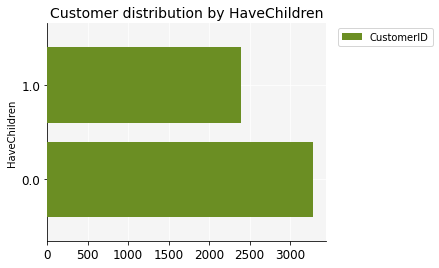

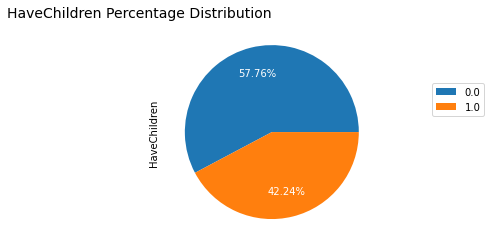

,HaveChildren,CustomerID
0,0.0,3280
1,1.0,2399
2,NaN,212


In [18]:
plot_demography('HaveChildren', 'olivedrab')
df_clean.groupby('HaveChildren', as_index=False, dropna=False)['CustomerID'].count().sort_values('CustomerID',ascending = False)

#### Customer City Type Distribution

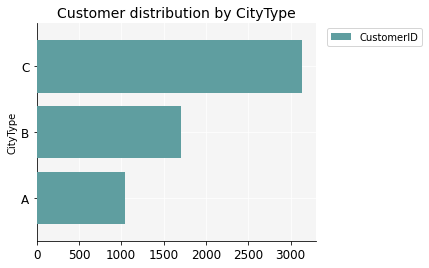

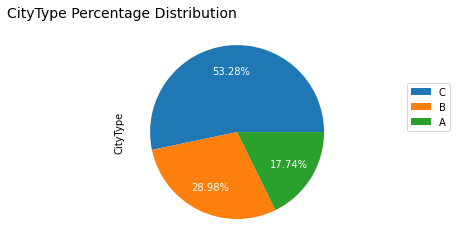

,CityType,CustomerID
2,C,3139
1,B,1707
0,A,1045


In [19]:
plot_demography('CityType', 'cadetblue')
show_table('CityType')

#### Customer Years In City Distribution

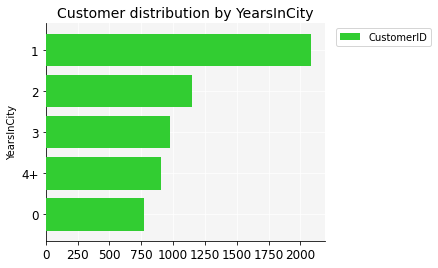

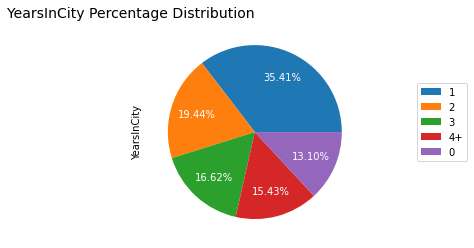

,YearsInCity,CustomerID
1,1,2086
2,2,1145
3,3,979
4,4+,909
0,0,772


In [20]:
plot_demography('YearsInCity', 'limegreen')
show_table('YearsInCity')

#### City Type VS Years in City 

In [21]:
display(df_clean.groupby('CityType')['YearsInCity'].value_counts().to_frame())
display(df_clean.groupby('CityType')['YearsInCity'].value_counts(normalize = True).to_frame())

YearsInCity
CityType YearsInCity             
A        1                    370
         2                    183
         3                    180
         4+                   165
         0                    147
B        1                    608
         2                    342
         3                    295
         4+                   251
         0                    211
C        1                   1108
         2                    620
         3                    504
         4+                   493
         0                    414

YearsInCity
CityType YearsInCity             
A        1               0.354067
         2               0.175120
         3               0.172249
         4+              0.157895
         0               0.140670
B        1               0.356180
         2               0.200351
         3               0.172818
         4+              0.147042
         0               0.123609
C        1               0.352979
         2               0.197515
         3               0.160561
         4+              0.157056
         0               0.131889

#### Most Popular Product Categories

In [48]:
category = ['Category_1','Category_2','Category_3','Category_4',\
                       'Category_5','Category_6','Category_7','Category_8',\
                       'Category_9','Category_10','Category_11','Category_12',\
                       'Category_13','Category_14','Category_15','Category_16','Category_17','Category_18']

categories = df_clean[category].sum().to_frame()
categories = categories.rename(columns={0:'count'}, index={'': 'one'})
categories.sort_values('count', ascending = False)

,count
Category_5,182249
Category_8,177803
Category_1,132452
Category_16,80804
Category_14,70889
Category_2,69370
Category_15,68620
Category_6,39469
Category_11,37900
Category_4,37166


<a id='Question3'></a>
### Customer Segmentation

<a href="#Table-of-Content">Back up</a>

**Demographic Segments**
1. ``Gender``: nearly 78% of the customer are **male**, only 22% are **female** .
2. ``Age``: customers with **26-45 years** old have occupied 55% of the whole customers. Among them, people with 26-35 (34.85%) are the most frequent buyers.
3. ``Profession``: there are in total 20 different professions appear in the customer data. But profession **4,0,7,1,17** occupied nearly 53% of the total customers. 
4. ``Have children or not``: the difference between number of customers with children or not is not as much as big as gender, but you can still see that customer **without** children are 16% more than customers with children. (58% VS 42%)

**Geographic Segments**
1. ``City type``: 53% of the customers live in **city C**. 
2. ``Years in the city``: customer who live in the **city 1 year** stand for 35.41% of the total customers, and customer with 2 years in city follows with 19.44%.
3. ``City type and years in the city``: in all type of the cities, people who live in city C moved to the city 1 and 2 years ago are still the largest group.

**Behavioral Segments**
1. ``Product Categories``: product **category 5, 8 ,1** are most popular categories for customers.

<a id='Question4'></a>
### Data points which can help to improve analysis

<a href="#Table-of-Content">Back up</a>

1. **Demographic data:**
    1. customer income
    2. customer household number/family size
    3. customer life cycle or status: married, single, kids number, etc.
    
    
2. **Geographic data:**
    1. Distance(kilometers) between the store and city where customer live.
    2. Appartment/house size.
    3. Appartment/house room number.
    
    
3. **Psychographic data:**
    1. customer lifestyle (casual, professional, homing, cosy...)
    2. Interests and hobby.
  
  
4. **Behavioral data:**
    1. Prefer online shopping or in store shopping?
    2. How often buy furnitures or decoration for home?
    3. Product purchase driver: price, quality, shipping speed, nice look, etc.
    
    
5. **Customer IKEA shopping historical data (RFM data):**
    1. Did they buy IKEA product before?
    2. How long they have been IKEA customers?
    3. When was the last time buy in IKEA?
    4. How frequent buy IKEA product?
    5. Do customers spend regularly during long term? Or spent once a lot and never come back?
    6. Average purchase amount for these customers?

<a id='Question5'></a>
### Prioritised customer segment

<a href="#Table-of-Content">Back up</a>

#### Firstly, let answer one question: Who spent most of money?

In [22]:
# define a bar char function to plot all the features
def plot_bar_chart(col,axs):
    c = df_clean.groupby(col, as_index=False ).agg({'CustomerID':'count', 'Amount': 'sum'})
    c['avg_spend'] =  round(c['Amount']/c['CustomerID'],2)
    c.reset_index(inplace=True)
    sns.barplot(x=col, y='avg_spend', data=c, ax=axs)
    axs.set_title('Customer spent by ' + str(col))

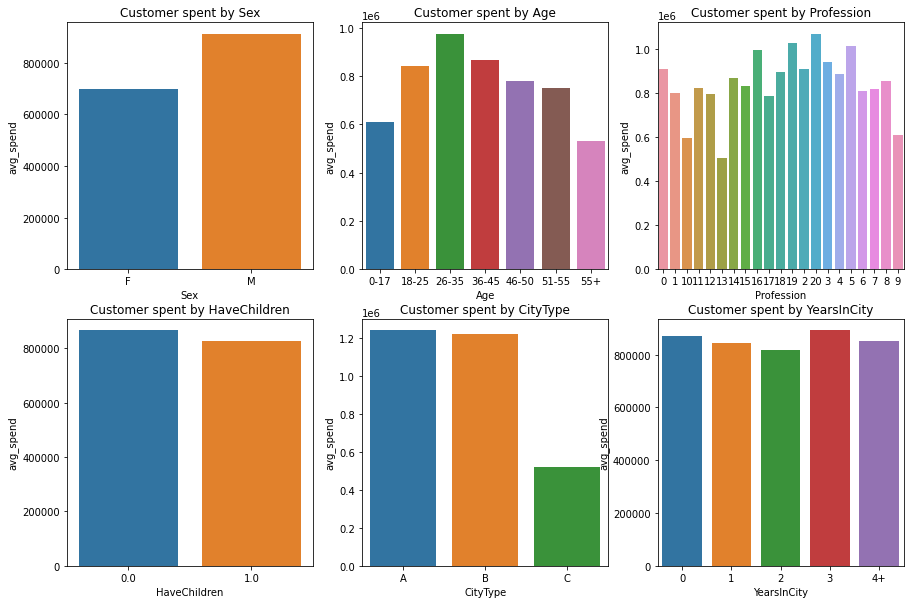

In [23]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

plot_bar_chart('Sex',ax[0,0])
plot_bar_chart('Age',ax[0,1])
plot_bar_chart('Profession',ax[0,2])
plot_bar_chart('HaveChildren',ax[1,0])
plot_bar_chart('CityType',ax[1,1])
plot_bar_chart('YearsInCity',ax[1,2])

In [51]:
# define a function to show the spend by features of the customers
def most_spender(feature):
    c = df_clean.groupby(feature, as_index=False ).agg({'CustomerID':'count', 'Amount': 'sum'})
    c['avg_spend'] =  round(c['Amount']/c['CustomerID'],2)
    c = c.rename(columns={'CustomerID':'Customer_count'})
    
    s = c['Amount'].sum()
    c['percentage'] = c['Amount'] / s
    
    return c.sort_values('avg_spend', ascending = False)

In [52]:
display(most_spender('Sex'))
display(most_spender('Age'))
display(most_spender('Profession'))
display(most_spender('CityType'))
display(most_spender('YearsInCity'))
display(most_spender('HaveChildren'))

,Sex,Customer_count,Amount,avg_spend,percentage
1,1,4078,12050084,2954.90,0.749897
0,0,1601,4018912,2510.25,0.250103


,Age,Customer_count,Amount,avg_spend,percentage
2,2,1981,6049223,3053.62,0.376453
3,3,1123,3205966,2854.82,0.199513
1,1,1024,2896838,2828.94,0.180275
4,4,515,1385885,2691.04,0.086246
5,5,462,1240185,2684.38,0.077179
0,0,211,504636,2391.64,0.031404
6,6,363,786263,2166.01,0.048930


,Profession,Customer_count,Amount,avg_spend,percentage
11,11,71,227619,3205.90,0.014165
13,13,262,836946,3194.45,0.052085
8,8,225,691017,3071.19,0.043003
16,16,107,327970,3065.14,0.020410
14,14,167,498834,2987.03,0.031043
12,12,249,738115,2964.32,0.045934
3,3,124,367312,2962.19,0.022858
4,4,362,1068099,2950.55,0.066470
7,7,132,384723,2914.57,0.023942
15,15,711,2066731,2906.79,0.128616


,CityType,Customer_count,Amount,avg_spend,percentage
1,1,1647,5733768,3481.34,0.356822
0,0,1005,3305971,3289.52,0.205736
2,2,3027,7029257,2322.19,0.437442


,YearsInCity,Customer_count,Amount,avg_spend,percentage
3,3,939,2704427,2880.11,0.168301
1,1,2011,5690407,2829.64,0.354123
4,4,873,2469642,2828.91,0.153690
2,2,1110,3115754,2806.99,0.193898
0,0,746,2088766,2799.95,0.129987


,HaveChildren,Customer_count,Amount,avg_spend,percentage
0,0,3280,9384631,2861.17,0.584021
1,1,2399,6684365,2786.31,0.415979


From the above analysis. We can obvious see the following points:
1. ``Gender``: Male spent more money than female, they spent 23% more than female customers in buy products in IKEA.
2. ``Age``: 26-35 years old group spent most comparing with the rest of age group. 36-45 age group follows.
3. ``Profession``: profession 20, 19 and 5 spent most of money than the rest.
4. ``City Type``: interesting thing to mention here is, city C has the most buyers for IKEA store, but city A and B spent most of the money on buying things. Customers who live in **city A** spent 2.4 times more than customers in city C.
5. ``Years in City``: something similar happened like city type segmentation. Most of the buyers lived 1 or 2 years in one city, but the **actual spender** are people who **lived 3 years** or new mover(0 year) in one city.
6. ``Have children or not``: the difference between both parties is not big, but people does not have children spent more than people who has children.

<a id='Question6'></a>
### Suggestion
<a href="#Table-of-Content">Back up</a>

Since the sales is our final goal. Here is my suggestion of the type of customers to focus on:
- Male
- 26-45 years old
- City A and B
- Who lived 3 years to one city or the new movers who just moved in the city.
- Without children.
- Possibly profession 20, 19 and 5.

<a id='Question7'></a>
### Have Chirldren or not prediction

<a href="#Table-of-Content">Back up</a>

There are several methods to predict it. What I am going to use are:
- Correlation coefficient calculation
- Machine learning model predition

#### Correlation Method

There are many ways to do correlations. But first of all, we need to convert the categorical data into numercial data to be able to calculate the correlations.

The most common ways to convert the categorical into numerical data is:
- **One-hot encoding**, in this method you can dummy all the categorical data into different columns, but I would not suggest to use this methos in this task, because we have many columns need to be encoded.
- **Label enconding**, this one is very common used, and I am going to use this method while I am doing machine learning models.
- **Cramér’s V**: based on Pearson’s Chi-Square Test. It sarts become a nice solution for categorical data problems. Which I am going to use this method for calculate the correlation in this case.

In [53]:
#df_children = df_clean[['CustomerID','Amount','ItemID','avg_price_per_unit','Sex','Age','Profession','CityType','YearsInCity','HaveChildren']]

In [54]:
# create the function for cramers v method
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [55]:
def create_correlation(df, method=cramers_v):
    tmp_data = {}
    columns = df.columns
    for x in columns:
        if not x in tmp_data.keys():
            tmp_data[x] = {}
        for y in columns:
            if not y in tmp_data.keys():
                tmp_data[y] = {}
            if y == x:
                tmp_data[x][y] = 1
                continue
            if y in tmp_data[x].keys():
                continue
            v = method(df[x], df[y])
            tmp_data[y][x] = v
            tmp_data[x][y] = v
    return pd.DataFrame(tmp_data)

In [56]:
df_corr = create_correlation(df_clean.drop(columns=['CustomerID', 'Amount'])).sort_values('HaveChildren', ascending = False)

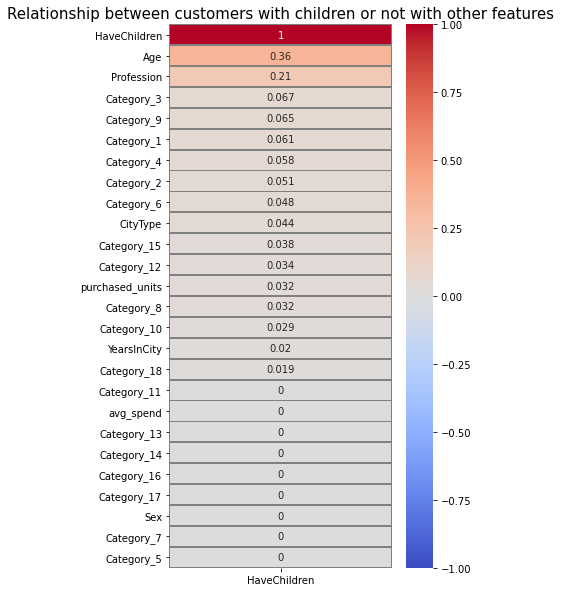

In [57]:
plt.figure(figsize=(5,10))
#mask = np.zeros_like(df_corr)
#mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_corr[['HaveChildren']], annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.8, linecolor='grey')
plt.title('Relationship between customers with children or not with other features', fontsize = 15)
plt.show()

In [58]:
cor_target = abs(df_corr['HaveChildren'])

cor_target.sort_values(ascending = False).to_frame()

,HaveChildren
HaveChildren,1.000000
Age,0.355122
Profession,0.214745
Category_3,0.066665
Category_9,0.064682
Category_1,0.061096
Category_4,0.058000
Category_2,0.051450
Category_6,0.047637
CityType,0.044091


#### Machine Learning Approach

We have do few things firstly before we start to apply the models:

1. Drop or fill all the null values
2. Encoding all the categorical data into numerical data

Then, I will try 4 different machine learning models and see which one has the highest accuracy:
- Decision Tree model
- Random Forest model
- Gradient Boosting model
- AdaBoost model

In [59]:
# drop null value and encoding the categorical data
df_clean = df_clean.dropna()

def Label_enc(feat):
    LabelE = LabelEncoder()
    LabelE.fit(feat)
    return LabelE.transform(feat)

for col in df_clean.columns:
    df_clean[str(col)] = Label_enc(df_clean[str(col)])

In [207]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import Imputer


scaler = MinMaxScaler()
df_clean[df_clean.columns] = scaler.fit_transform(df_clean[df_clean.columns].to_numpy())

In [232]:
# Reshape imbalanced data

# target = df_clean['HaveChildren']
# features = df_clean.drop(['HaveChildren','CustomerID','Category_11','avg_spend','Amount','purchased_units'], axis =1)

#X_train, X_test, y_train, y_test = train_test_split(features, 
 #                                                 target, 
  #                                                test_size = 0.2, 
   #                                                 random_state = 42)

# concatenate our training data back together
#X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
#not_children = X[X['HaveChildren']==0]
#children = X[X['HaveChildren']==1]

# upsample minority
#children_upsampled = resample(children,
 #                         replace=True, # sample with replacement
  #                        n_samples=len(not_children), # match number in majority class
   #                       random_state=27) # reproducible results

# combine majority and upsampled minority
#upsampled = pd.concat([not_children, fraud_upsampled])

#y_train = upsampled.HaveChildren
#X_train = upsampled.drop('HaveChildren', axis=1)

In [270]:
target = df_clean['HaveChildren']
features = df_clean.drop(['HaveChildren','CustomerID','Amount','purchased_units','avg_spend'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [271]:
def train_predict(model, sample_size, X_train, y_train, X_test, y_test): 
    
    results = {}
    
    start = time()
    model = model.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
        
    start = time()
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start            
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)        
    results['acc_test'] = accuracy_score(y_test,predictions_test)    
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)        
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    print("{} trained on {} samples.".format(model.__class__.__name__, sample_size))
        
    return results

RidgeClassifierCV trained on 45 samples.
RidgeClassifierCV trained on 454 samples.
RidgeClassifierCV trained on 4543 samples.
[21:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 45 samples.
[21:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier trained on 454 samples.
[21:45:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

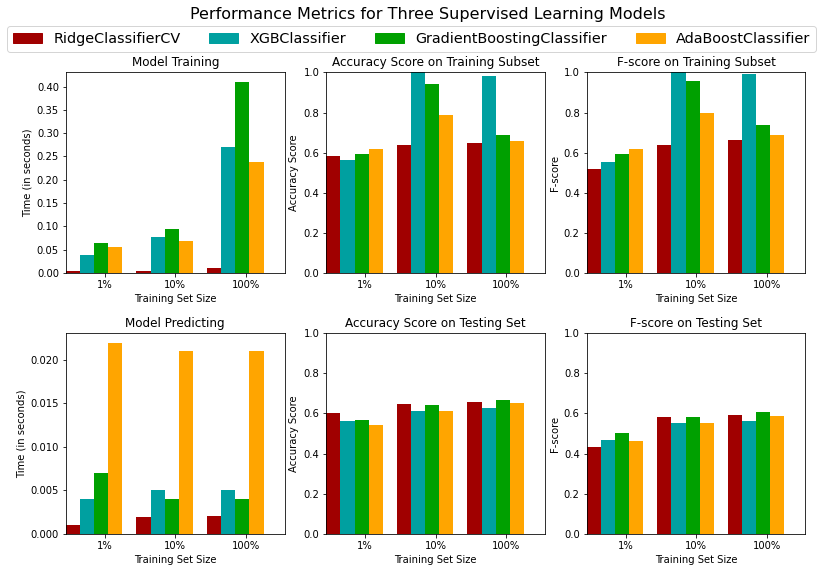

In [272]:
# Try one these 4 different models
clf_A = RidgeClassifierCV()
clf_B = XGBClassifier()
clf_C = GradientBoostingClassifier()
clf_D = AdaBoostClassifier(random_state=101)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the models
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy_score, f1_score)

In [273]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RidgeClassifierCV


,1%,10%,100%
train_time,0.003990,0.004025,0.009970
pred_time,0.000998,0.001961,0.001994
acc_train,0.583333,0.636667,0.646667
acc_test,0.600352,0.646127,0.657570
f_train,0.520134,0.639731,0.663507
f_test,0.433628,0.584659,0.590501


XGBClassifier


,1%,10%,100%
train_time,0.038895,0.076795,0.271274
pred_time,0.003989,0.004987,0.004987
acc_train,0.563333,1.000000,0.983333
acc_test,0.562500,0.610915,0.629401
f_train,0.551118,1.000000,0.993151
f_test,0.468599,0.550201,0.561127


GradientBoostingClassifier


,1%,10%,100%
train_time,0.064828,0.093749,0.409905
pred_time,0.006982,0.003990,0.004024
acc_train,0.593333,0.943333,0.690000
acc_test,0.565141,0.640845,0.667254
f_train,0.591922,0.955679,0.737327
f_test,0.501175,0.584074,0.608935


AdaBoostClassifier


,1%,10%,100%
train_time,0.056812,0.067853,0.238362
pred_time,0.021942,0.020945,0.020943
acc_train,0.616667,0.786667,0.660000
acc_test,0.540493,0.610915,0.654049
f_train,0.616246,0.799712,0.687204
f_test,0.464197,0.552303,0.585697


From these training results, we can see that among these 4 models, Gradient Boosting models is working best because it has the higest test data accuracy and test data f1 score.

So I will try to tune this model to get better results

In [296]:
# Use grid search cv to tune the model and try to find the best parameters of this model
from sklearn.model_selection import GridSearchCV

parameters = [{
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters, cv=5,
                       scoring='neg_mean_squared_error')
grid_fit = grid_search.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
best_params = grid_fit.best_params_

In [253]:
Model = GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.1,
                           loss='deviance', max_depth=3, 
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=40)

train_predict( Model,len(y_train), X_train, y_train, X_test, y_test)

GradientBoostingClassifier trained on 4543 samples.


{'train_time': 36.18018674850464,
 'pred_time': 0.002989530563354492,
 'acc_train': 0.66,
 'acc_test': 0.6602112676056338,
 'f_train': 0.6896551724137931,
 'f_test': 0.5959849435382685}

In [254]:
Model = RidgeClassifier(alpha = 10, max_iter=1)

train_predict( Model,len(y_train), X_train, y_train, X_test, y_test)

RidgeClassifier trained on 4543 samples.


{'train_time': 0.006981611251831055,
 'pred_time': 0.001993417739868164,
 'acc_train': 0.6466666666666666,
 'acc_test': 0.6558098591549296,
 'f_train': 0.6635071090047393,
 'f_test': 0.5872913992297818}

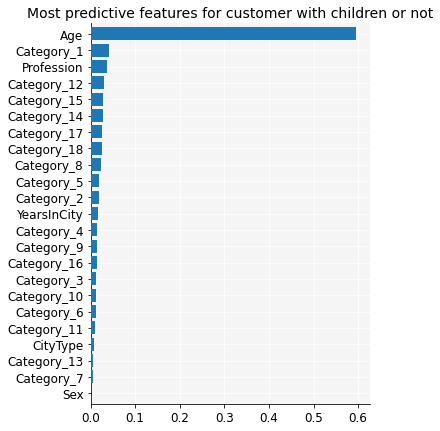

In [274]:
model = GradientBoostingClassifier().fit(X_train,y_train)

importances = model.feature_importances_

feat_imp = pd.Series(model.feature_importances_, index=features.columns)
ax = feat_imp.nsmallest(30).plot(kind='barh', figsize=(5,7),fontsize=12, width = 0.8, zorder=3)
ax.set_title("Most predictive features for customer with children or not", fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax.grid(color = 'w', zorder=0)

for spine in ax.spines:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_facecolor('whitesmoke')

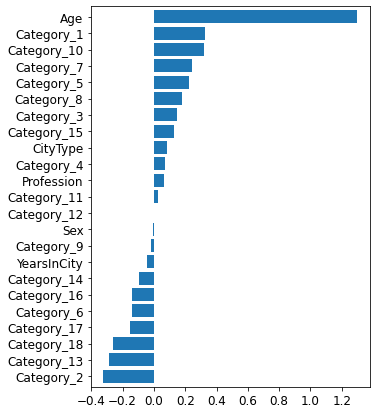

In [275]:
from sklearn.datasets import make_regression
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RidgeClassifier()
# fit the model
model.fit(X_train,y_train)
# get importance

importance = model.coef_
# summarize feature importance

importance= importance[0]

feat_imp = pd.Series(importance, index=features.columns)
ax = feat_imp.nsmallest(30).plot(kind='barh', figsize=(5,7),fontsize=12, width = 0.8, zorder=3)

<a id='Question8'></a>
### Prediction Summary

<a href="#Table-of-Content">Back up</a>

**Correlation method**

As we can see from the graph and the list of the features which have the highest correlation with ``Have Children or not``, we can see the **most predictive features** are :
1. Age
2. Profession

**Machine learning method**

From the machine learning models prediction, we can see that the most predictive feature to customer have children or not will be **Age**. Like the method we used for calculation the correlation.

In [165]:

from numpy import loadtxt
from xgboost import XGBClassifier